# Plant Disease Classifications with PyTorch

# 1. Try the CNN architecture with train and validation sets only

## 1.1. Import all libraries required

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 1.2. Data preparation

In [2]:
data_dir = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/PlantVillage"

train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

## 1.3. Split dataset

In [3]:
full_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transforms

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4, pin_memory=True)

class_names = full_dataset.classes
print(f"Number of classes: {len(class_names)}")
print(class_names)

Number of classes: 15
['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


## 1.4. Create CNN architecture

In [4]:
class PlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes=15):
        super(PlantDiseaseCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## 1.5. Initialize model, loss and optimizer

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PlantDiseaseCNN(num_classes=len(class_names)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 1.6. Training loop

In [6]:
epochs = 15
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total

    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_losses[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f} | "
          f"Val Acc: {acc*100:.2f}%")

C:\Users\ekadw\anaconda3\envs\PyTorch\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/15 | Train Loss: 1.4608 | Val Loss: 0.8762 | Val Acc: 71.83%
Epoch 2/15 | Train Loss: 0.8589 | Val Loss: 0.5750 | Val Acc: 80.35%
Epoch 3/15 | Train Loss: 0.6835 | Val Loss: 0.4078 | Val Acc: 86.53%
Epoch 4/15 | Train Loss: 0.5722 | Val Loss: 0.3765 | Val Acc: 87.35%
Epoch 5/15 | Train Loss: 0.4947 | Val Loss: 0.2577 | Val Acc: 91.09%
Epoch 6/15 | Train Loss: 0.4292 | Val Loss: 0.2915 | Val Acc: 90.72%
Epoch 7/15 | Train Loss: 0.3733 | Val Loss: 0.2111 | Val Acc: 93.56%
Epoch 8/15 | Train Loss: 0.3458 | Val Loss: 0.1988 | Val Acc: 93.70%
Epoch 9/15 | Train Loss: 0.2862 | Val Loss: 0.1755 | Val Acc: 94.26%
Epoch 10/15 | Train Loss: 0.2921 | Val Loss: 0.1902 | Val Acc: 93.60%
Epoch 11/15 | Train Loss: 0.2189 | Val Loss: 0.2258 | Val Acc: 93.02%
Epoch 12/15 | Train Loss: 0.2331 | Val Loss: 0.1525 | Val Acc: 95.83%
Epoch 13/15 | Train Loss: 0.1956 | Val Loss: 0.1421 | Val Acc: 95.54%
Epoch 14/15 | Train Loss: 0.1837 | Val Loss: 0.1629 | Val Acc: 95.20%
Epoch 15/15 | Train Loss: 0.1

## 1.7. Visualize the result

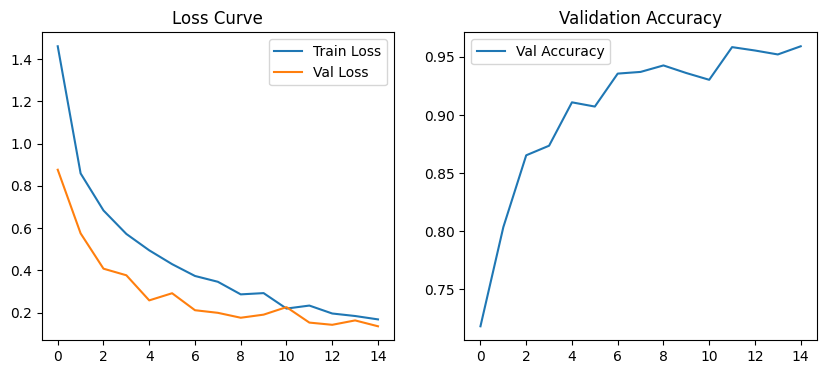

In [7]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend(); plt.title("Validation Accuracy")
plt.show()

## 1.8. Confusion matrix

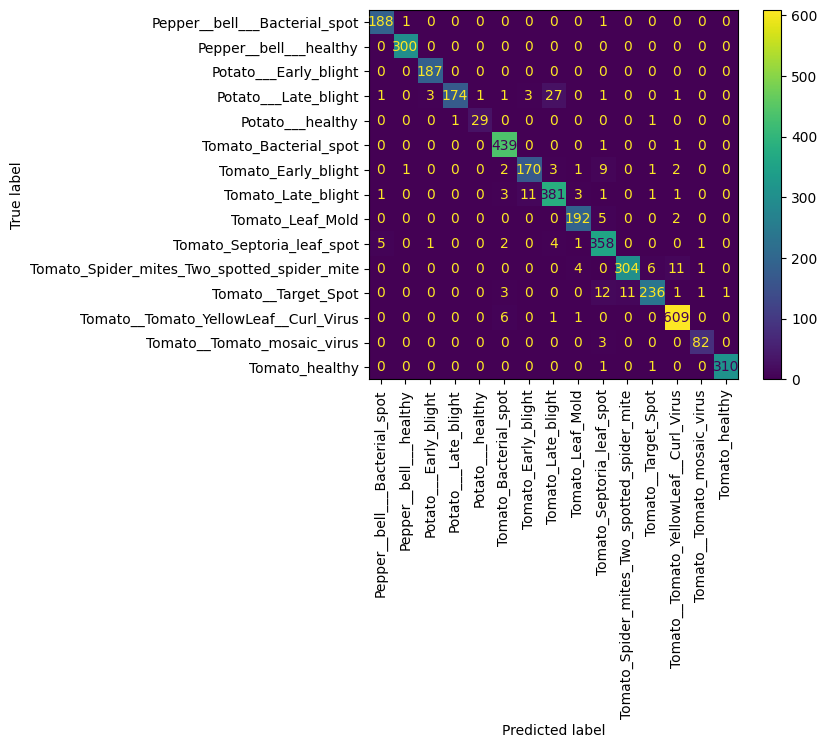

In [8]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(xticks_rotation=90, cmap='viridis')
plt.show()

Result: The result of the training and validation sets are good with no sign of overfitting. When the training loss is decreasing, the validation loss has the same pattern too. It means the same architecture is safe for the train and testing process as shown in the next step.

# 2. Classification process with train, testing and validation sets

## 2.1 Split train, test and validation set

In [10]:
from torch.utils.data import random_split, DataLoader

data_dir = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/PlantVillage"

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
num_classes = len(dataset.classes)

# Split the dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4, pin_memory=True)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")
print(f"Classes: {dataset.classes}")


Train: 14446, Validation: 3095, Test: 3097
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


## 2.2 Create CNN model architecture

In [11]:
class PlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes=15):
        super(PlantDiseaseCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


## 2.3 Training setup

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PlantDiseaseCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## 2.4 Training and validation

In [13]:
epochs = 15
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_losses[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f} | "
          f"Val Acc: {val_acc*100:.2f}%")


C:\Users\ekadw\anaconda3\envs\PyTorch\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/15] Train Loss: 1.5214 | Val Loss: 0.7940 | Val Acc: 72.99%
Epoch [2/15] Train Loss: 0.8906 | Val Loss: 0.4806 | Val Acc: 83.59%
Epoch [3/15] Train Loss: 0.7359 | Val Loss: 0.3981 | Val Acc: 86.95%
Epoch [4/15] Train Loss: 0.6133 | Val Loss: 0.3231 | Val Acc: 89.43%
Epoch [5/15] Train Loss: 0.5279 | Val Loss: 0.3938 | Val Acc: 86.98%
Epoch [6/15] Train Loss: 0.4791 | Val Loss: 0.3387 | Val Acc: 89.18%
Epoch [7/15] Train Loss: 0.4189 | Val Loss: 0.2085 | Val Acc: 93.28%
Epoch [8/15] Train Loss: 0.3781 | Val Loss: 0.2779 | Val Acc: 91.44%
Epoch [9/15] Train Loss: 0.3458 | Val Loss: 0.2035 | Val Acc: 93.70%
Epoch [10/15] Train Loss: 0.3115 | Val Loss: 0.2120 | Val Acc: 93.60%
Epoch [11/15] Train Loss: 0.2820 | Val Loss: 0.1959 | Val Acc: 93.44%
Epoch [12/15] Train Loss: 0.2716 | Val Loss: 0.1568 | Val Acc: 94.89%
Epoch [13/15] Train Loss: 0.2428 | Val Loss: 0.1497 | Val Acc: 95.38%
Epoch [14/15] Train Loss: 0.2171 | Val Loss: 0.1314 | Val Acc: 95.99%
Epoch [15/15] Train Loss: 0.1

## 2.5 Visualize the train loss, validation loss and validation accuracy

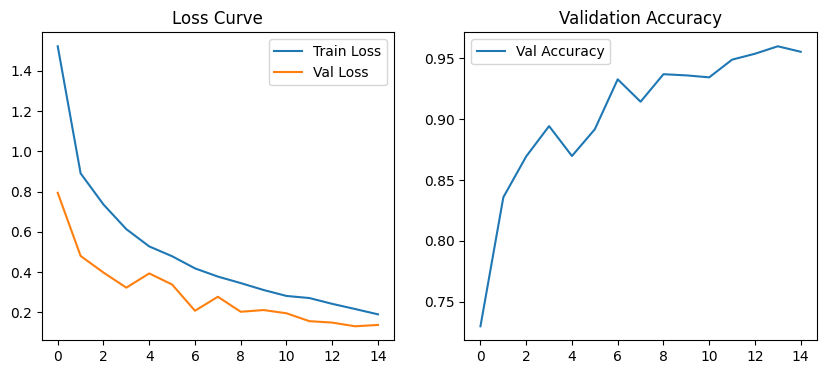

In [18]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend(); plt.title("Validation Accuracy")
plt.show()

## 2.6 Evaluate on test dataset

In [14]:
model.eval()
test_loss, correct, total = 0, 0, 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"\n Test Accuracy: {test_acc*100:.2f}%")


✅ Test Accuracy: 95.48%


## 2.7 Do the prediction

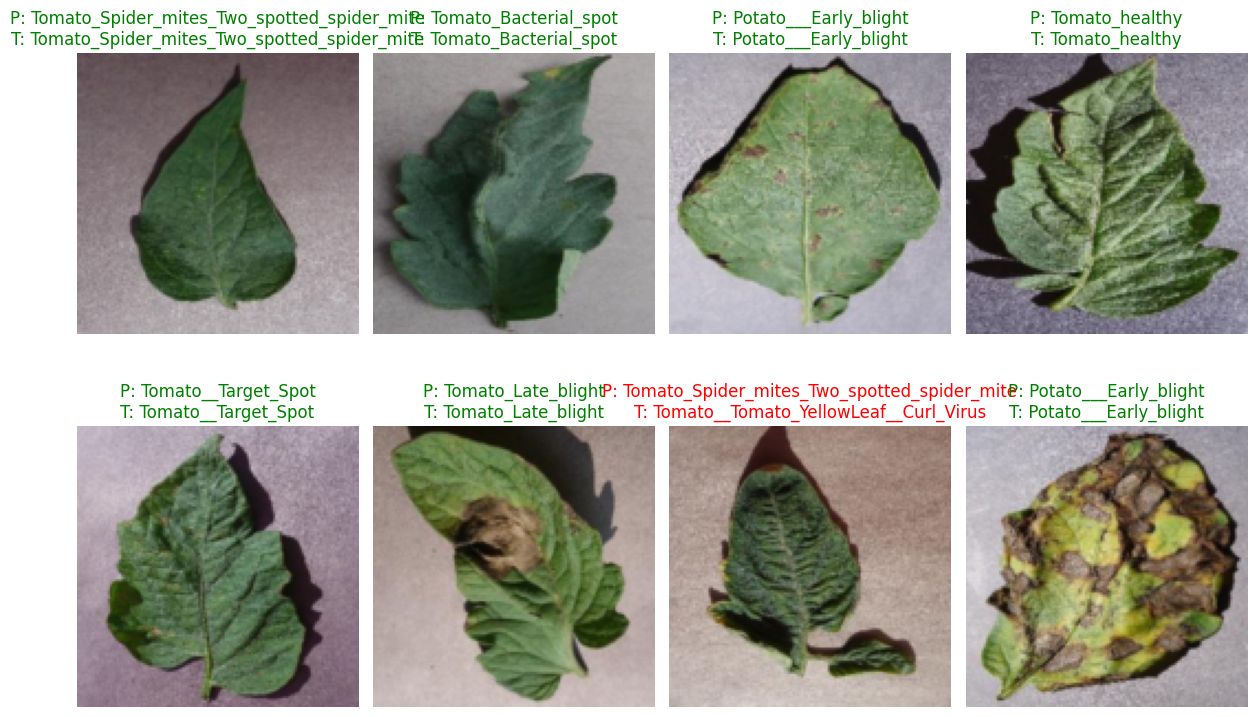

In [15]:
import matplotlib.pyplot as plt
import random

# Helper to unnormalize image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Get some random test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Plot predictions
plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    imshow(images[i].cpu())
    true_label = dataset.classes[labels[i]]
    pred_label = dataset.classes[preds[i]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"P: {pred_label}\nT: {true_label}", color=color)
    plt.axis("off")
plt.tight_layout()
plt.show()

Result: the test accuracy is 95.48%, without sign of overfitting because the when the train loss is decreasing the validation test is decreasing too. We know that the data is imbalance, but PyTorch is quite good to handle the imbalance dataset even without do the augmentation for the minority classes and down sampling to the majority classes as we did on TensorFlow.